Scrape the following sites using Playwright and the magical scraping prompt.

### 1. All the wells in North Dakota 
Scraping: https://www.dmr.nd.gov/oilgas/findwellsvw.asp

In [ ]:
%pip install playwright
%playwright install firefox

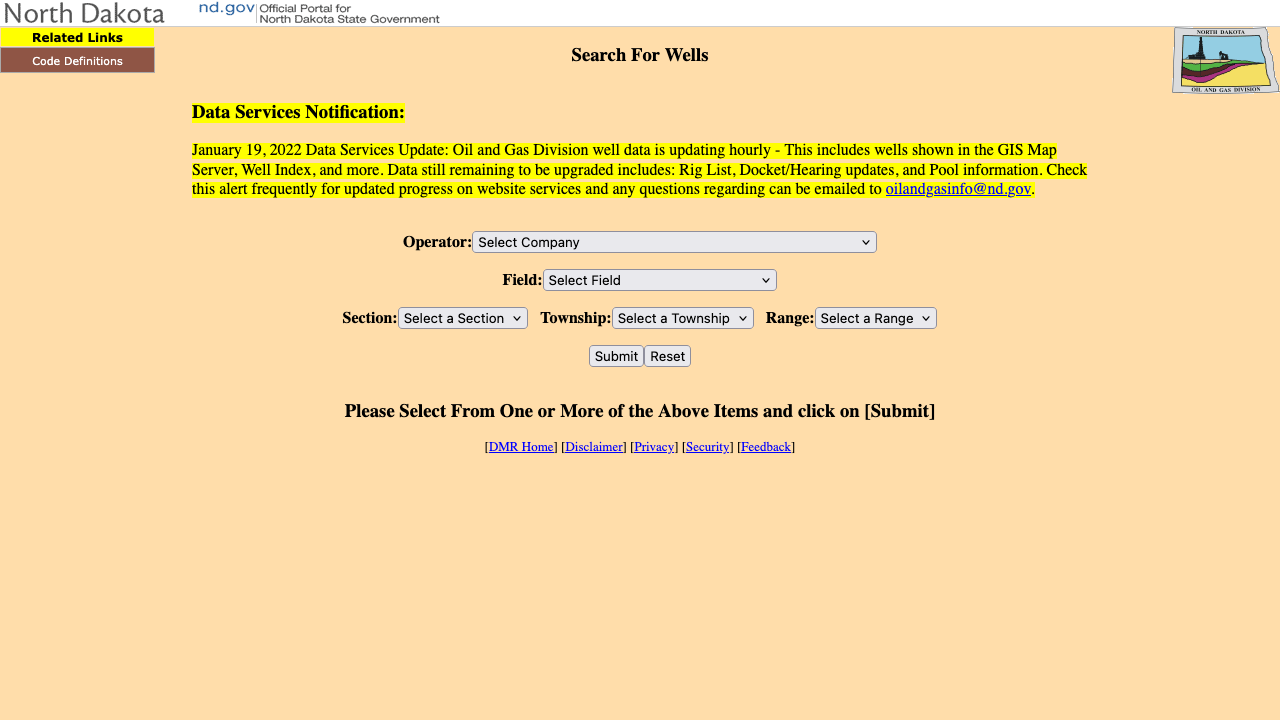

In [1]:
import asyncio
from playwright.async_api import async_playwright
from IPython.display import display, Image
import nest_asyncio

nest_asyncio.apply()  # Allows asyncio to run inside Jupyter

async def load_page():
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()
        await page.goto("https://www.dmr.nd.gov/oilgas/findwellsvw.asp", wait_until="networkidle")
        screenshot_bytes = await page.screenshot()
        display(Image(data=screenshot_bytes))
        await browser.close()

# Run the async function in Jupyter
asyncio.get_event_loop().run_until_complete(load_page())


In [2]:
import asyncio
from playwright.async_api import async_playwright
import nest_asyncio

nest_asyncio.apply()

async def get_dropdown_options():
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()
        await page.goto("https://www.dmr.nd.gov/oilgas/findwellsvw.asp", wait_until="networkidle")
        
        # Function to get options for a select element by its ID
        async def get_options(select_id):
            return await page.eval_on_selector_all(
                f"#{select_id} option",
                "options => options.map(o => ({value: o.value, text: o.textContent.trim()})).filter(o => o.value != '0')"
            )
        
        operators = await get_options("ddmOperator")
        fields = await get_options("ddmField")
        sections = await get_options("ddmSection")
        townships = await get_options("ddmTownship")
        ranges = await get_options("ddmRange")
        
        await browser.close()
        
        return operators, fields, sections, townships, ranges

# Run the async function
operators, fields, sections, townships, ranges = asyncio.get_event_loop().run_until_complete(get_dropdown_options())

# Preview the first 5 options of each dropdown
print("Operators:", operators[:5])
print("Fields:", fields[:5])
print("Sections:", sections[:5])
print("Townships:", townships[:5])
print("Ranges:", ranges[:5])

Operators: [{'value': ' ', 'text': 'Select Company'}, {'value': '3 TS SWD LLC', 'text': '3 TS SWD LLC'}, {'value': '31 OPERATING, LLC', 'text': '31 OPERATING, LLC'}, {'value': '4J Well Service, Inc', 'text': '4J Well Service, Inc'}, {'value': 'A & A ROBILLARD CO.', 'text': 'A & A ROBILLARD CO.'}]
Fields: [{'value': ' ', 'text': 'Select Field'}, {'value': 'ALEXANDER', 'text': 'ALEXANDER'}, {'value': 'ALEXANDRIA', 'text': 'ALEXANDRIA'}, {'value': 'ALGER', 'text': 'ALGER'}, {'value': 'ALKABO', 'text': 'ALKABO'}]
Sections: [{'value': '1', 'text': '1'}, {'value': '2', 'text': '2'}, {'value': '3', 'text': '3'}, {'value': '4', 'text': '4'}, {'value': '5', 'text': '5'}]
Townships: [{'value': '129', 'text': '129'}, {'value': '130', 'text': '130'}, {'value': '131', 'text': '131'}, {'value': '132', 'text': '132'}, {'value': '133', 'text': '133'}]
Ranges: [{'value': '107', 'text': '107'}, {'value': '106', 'text': '106'}, {'value': '105', 'text': '105'}, {'value': '104', 'text': '104'}, {'value': '

In [4]:
import requests
from bs4 import BeautifulSoup

url = "https://www.dmr.nd.gov/oilgas/findwellsvw.asp"

# Load the page
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Function to get dropdown options by ID (skip "Select ..." default)
def get_options(select_id):
    select = soup.find("select", {"id": select_id})
    options = []
    for opt in select.find_all("option"):
        value = opt.get("value")
        text = opt.get_text(strip=True)
        if value != "0":
            options.append({"value": value, "text": text})
    return options

operators = get_options("ddmOperator")
fields = get_options("ddmField")
sections = get_options("ddmSection")
townships = get_options("ddmTownship")
ranges = get_options("ddmRange")

# Preview first 5 of each
print("Operators:", operators[:5])
print("Fields:", fields[:5])
print("Sections:", sections[:5])
print("Townships:", townships[:5])
print("Ranges:", ranges[:5])

Operators: [{'value': ' ', 'text': 'Select Company'}, {'value': '3 TS SWD LLC', 'text': '3 TS SWD LLC'}, {'value': '31 OPERATING, LLC', 'text': '31 OPERATING, LLC'}, {'value': '4J Well Service, Inc', 'text': '4J Well Service, Inc'}, {'value': 'A & A ROBILLARD CO.', 'text': 'A & A ROBILLARD CO.'}]
Fields: [{'value': ' ', 'text': 'Select Field'}, {'value': 'ALEXANDER', 'text': 'ALEXANDER'}, {'value': 'ALEXANDRIA', 'text': 'ALEXANDRIA'}, {'value': 'ALGER', 'text': 'ALGER'}, {'value': 'ALKABO', 'text': 'ALKABO'}]
Sections: [{'value': '1', 'text': '1'}, {'value': '2', 'text': '2'}, {'value': '3', 'text': '3'}, {'value': '4', 'text': '4'}, {'value': '5', 'text': '5'}]
Townships: [{'value': '129', 'text': '129'}, {'value': '130', 'text': '130'}, {'value': '131', 'text': '131'}, {'value': '132', 'text': '132'}, {'value': '133', 'text': '133'}]
Ranges: [{'value': '107', 'text': '107'}, {'value': '106', 'text': '106'}, {'value': '105', 'text': '105'}, {'value': '104', 'text': '104'}, {'value': '

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm

# Base URL
url = "https://www.dmr.nd.gov/oilgas/findwellsvw.asp"

# Township values (129–164)
township_values = [str(i) for i in range(129, 165)]
all_wells = []

# Loop through Townships with progress bar
for t_value in tqdm(township_values, desc="Scraping Townships"):
    data = {
        "ddmTownship": t_value,
        "B1": "Submit"  # the submit button
    }
    
    try:
        response = requests.post(url, data=data)
        response.raise_for_status()
    except:
        print(f"Failed for Township {t_value}")
        continue
    
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Find the table by header
    well_table = None
    for tbl in soup.find_all("table"):
        headers = [th.get_text(strip=True) for th in tbl.find_all("th")]
        if "API No" in headers:
            well_table = tbl
            break
    
    if not well_table:
        # No results for this Township
        continue
    
    # Extract rows
    rows = well_table.find_all("tr")[1:]  # skip header
    for row in rows:
        cells = row.find_all("td")
        if len(cells) != 11:
            continue
        well = {
            "File No": cells[0].get_text(strip=True),
            "CTB No": cells[1].get_text(strip=True),
            "API No": cells[2].get_text(strip=True),
            "Well Type": cells[3].get_text(strip=True),
            "Well Status": cells[4].get_text(strip=True),
            "Status Date": cells[5].get_text(strip=True),
            "DTD": cells[6].get_text(strip=True),
            "Location": cells[7].get_text(strip=True),
            "Operator": cells[8].get_text(strip=True),
            "Well Name": cells[9].get_text(strip=True),
            "Field": cells[10].get_text(strip=True)
        }
        all_wells.append(well)

# Convert to DataFrame and save CSV
df = pd.DataFrame(all_wells)
print(f"Scraped {len(df)} wells in total.")

output_file = "/tmp/ND_wells.csv"
df.to_csv(output_file, index=False)
print(f"Saved to {output_file}")


Scraping Townships:   0%|          | 0/36 [00:00<?, ?it/s]

Scraped 43150 wells in total.
Saved to /tmp/ND_wells.csv


In [6]:
# Save to your Desktop (adjust the path as needed)
output_file = "/Users/luizaswierzawska1/Desktop/cool-things-soma/ND_wells.csv"
df.to_csv(output_file, index=False)
print(f"CSV saved as '{output_file}'")

CSV saved as '/Users/luizaswierzawska1/Desktop/cool-things-soma/ND_wells.csv'


### Cosmetology violations for licensees with the last name NGUYEN

Scraping: https://www.tdlr.texas.gov/cimsfo/fosearch.asp

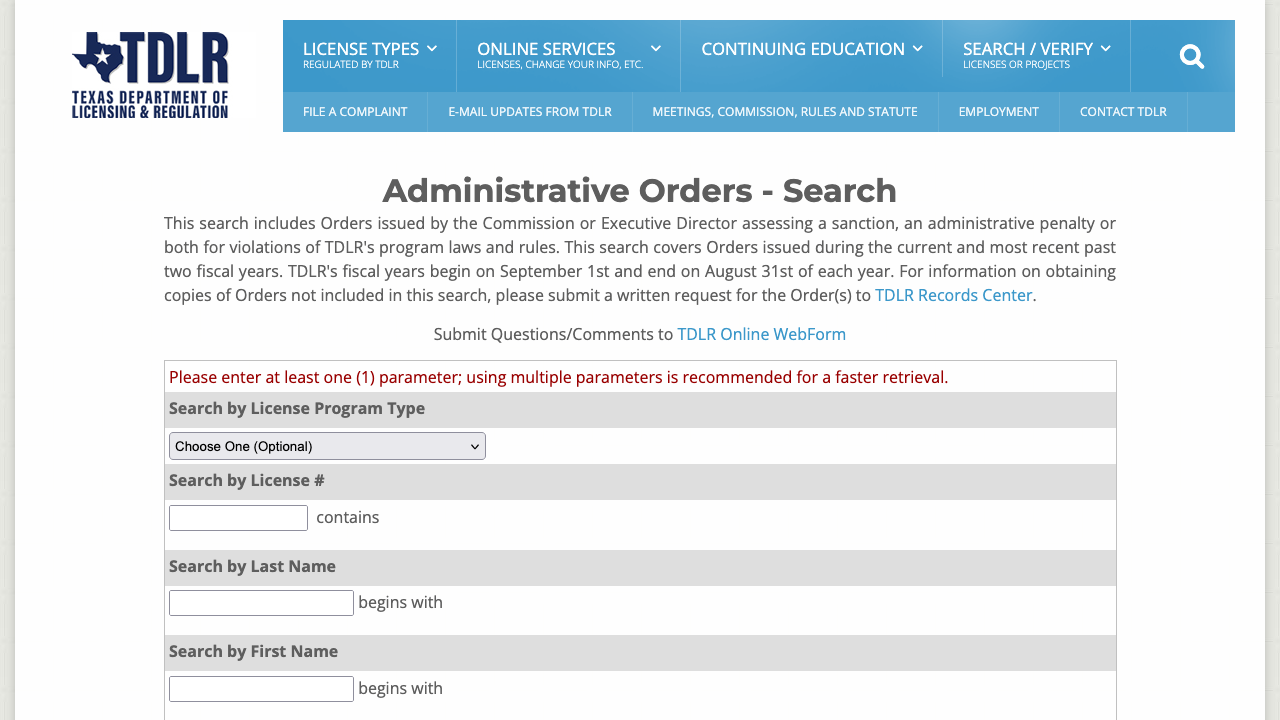

In [7]:
# Simple test: just open page and screenshot
async def test_page():
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()
        await page.goto("https://www.tdlr.texas.gov/cimsfo/fosearch.asp", wait_until="networkidle")
        screenshot = await page.screenshot()
        display(Image(screenshot))
        await browser.close()

# Run it
asyncio.run(test_page())

In [8]:
async def inspect_form():
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=False)  # headless=False so you can see the page
        page = await browser.new_page()
        await page.goto("https://www.tdlr.texas.gov/cimsfo/fosearch.asp", wait_until="networkidle")
        
        # Print the HTML of the entire page (or a portion)
        html = await page.content()
        print(html[:2000])  # first 2000 characters for inspection
        
        # Keep browser open so you can inspect manually
        return page

page = asyncio.run(inspect_form())

<!DOCTYPE ><html lang="en" class=" supports csstransforms3d"><head>
    <title>Administrative Orders - Search</title>
    <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
	<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1">
	<link rel="shortcut icon" href="/images/favicon.png" type="image/x-icon">

    <!-- Google Tag Manager -->
    <script type="text/javascript" async="" src="https://www.googletagmanager.com/gtag/js?id=G-8C39DM76B2&amp;cx=c&amp;gtm=4e5c31"></script><script async="" src="https://www.googletagmanager.com/gtm.js?id=GTM-MPP5WF5"></script><script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':
    new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],
    j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src=
    'https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);
    })(window,document,'script','dataLayer','GTM-MPP5WF5');</script>
    <!-- End 

Launching Firefox…
Navigating to search page…
Filling Last Name…
Selecting Cosmetology…
Clicking Search button…
Waiting for results table…
Results loaded!


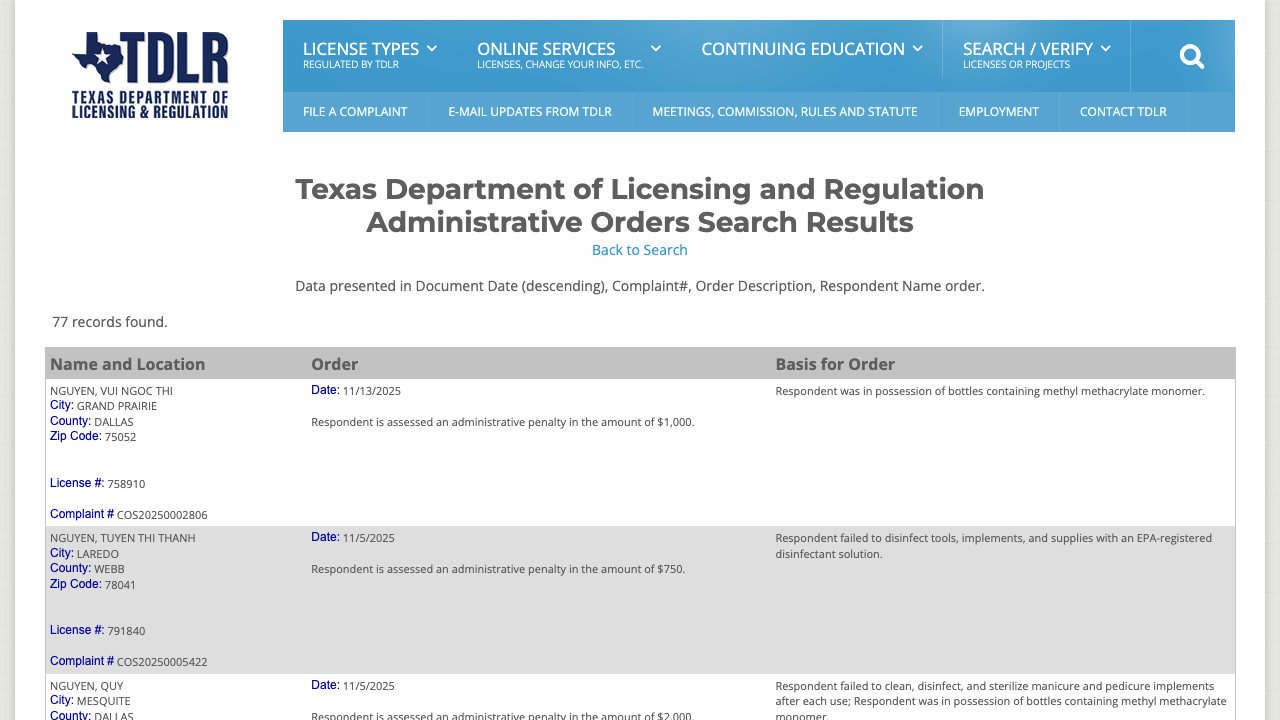

Extracting HTML…
Found 77 data rows.


Parsing rows:   0%|          | 0/77 [00:00<?, ?row/s]

Browser closed. Scraping complete!
CSV saved as '/Users/luizaswierzawska1/Desktop/cool-things-soma/ND_wells.csv'


In [9]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Image
import os

async def scrape_tdlr_nguyen():
    async with async_playwright() as p:
        print("Launching Firefox…")
        browser = await p.firefox.launch(headless=False)  # headless=True to run in background
        context = await browser.new_context()
        page = await context.new_page()

        print("Navigating to search page…")
        await page.goto("https://www.tdlr.texas.gov/cimsfo/fosearch.asp", wait_until="networkidle")

        print("Filling Last Name…")
        await page.fill("input#pht_lnm", "NGUYEN")

        print("Selecting Cosmetology…")
        await page.select_option("select#pht_status", value="COS")

        print("Clicking Search button…")
        await page.click("input[type='submit'][name='B1'][value='Search']")

        print("Waiting for results table…")
        await page.wait_for_selector("th:has-text('Name and Location')", timeout=60000)
        print("Results loaded!")

        # Screenshot to verify
        screenshot = await page.screenshot()
        display(Image(screenshot))

        print("Extracting HTML…")
        content = await page.content()
        soup = BeautifulSoup(content, "html.parser")

        # Find the results table by header text
        header = soup.find("th", string=lambda x: x and "Name and Location" in x)
        table = header.find_parent("table")

        rows = table.find_all("tr")[1:]  # skip header row
        print(f"Found {len(rows)} data rows.")

        # Extract data
        data = []
        for row in tqdm(rows, desc="Parsing rows", unit="row"):
            cols = row.find_all("td")
            if len(cols) >= 3:
                spans = cols[0].find_all("span")
                name = spans[0].get_text(strip=True) if len(spans) > 0 else ""
                city = spans[1].get_text(strip=True) if len(spans) > 1 else ""
                county = spans[2].get_text(strip=True) if len(spans) > 2 else ""
                zip_code = spans[3].get_text(strip=True) if len(spans) > 3 else ""
                license_number = spans[4].get_text(strip=True) if len(spans) > 4 else ""
                complaint_number = spans[5].get_text(strip=True) if len(spans) > 5 else ""

                order = cols[1].get_text(strip=True)
                basis = cols[2].get_text(strip=True)

                data.append({
                    "Name": name,
                    "City": city,
                    "County": county,
                    "Zip Code": zip_code,
                    "License #": license_number,
                    "Complaint #": complaint_number,
                    "Order / Penalty": order,
                    "Violation Details": basis
                })

        df = pd.DataFrame(data)

        await browser.close()
        print("Browser closed. Scraping complete!")

        return df

# Run the scraper
df = asyncio.run(scrape_tdlr_nguyen())

# Preview results
df.head()

# Save CSV to Desktop folder (create folder if it doesn't exist)
desktop_folder = "/Users/luizaswierzawska1/Desktop/cool-things-soma"
os.makedirs(desktop_folder, exist_ok=True)

output_file = os.path.join(desktop_folder, "ND_wells.csv")
df.to_csv(output_file, index=False)
print(f"CSV saved as '{output_file}'")


### All the tow truck licenses in Houston

Scraping: https://www.tdlr.texas.gov/tools_search/

Scraping ZIP codes:   0%|          | 0/10 [00:00<?, ?it/s]

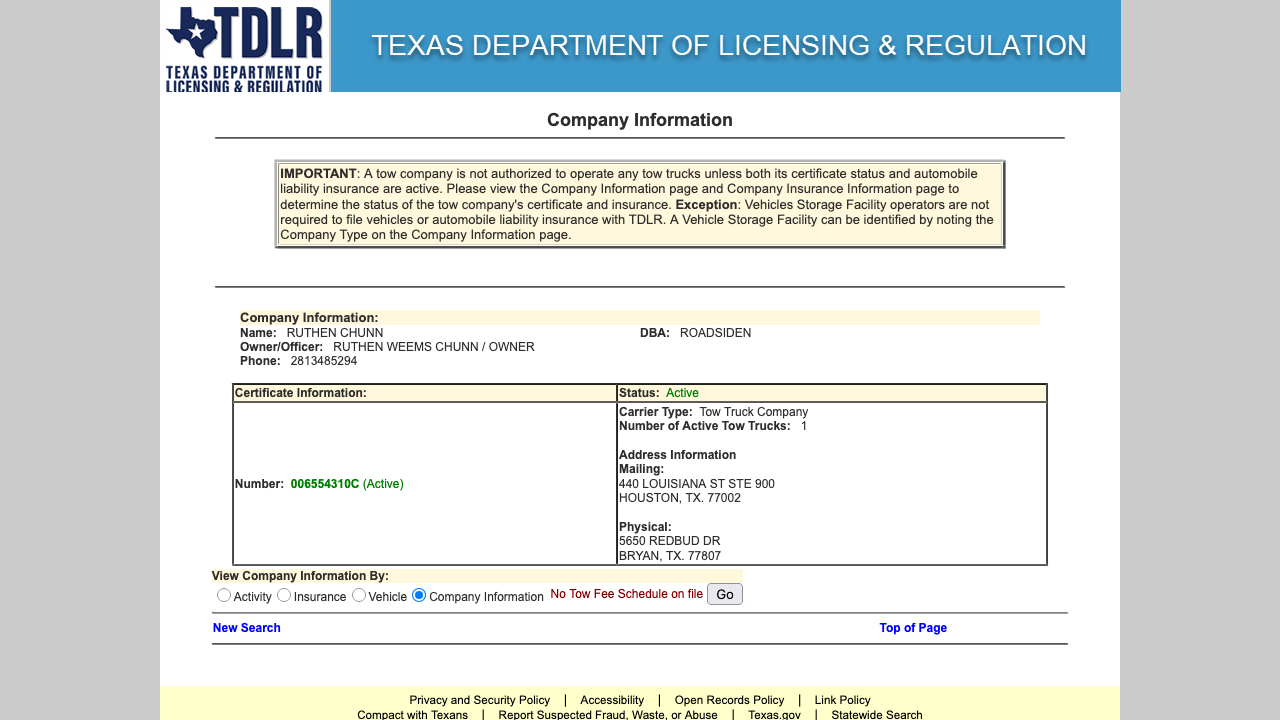

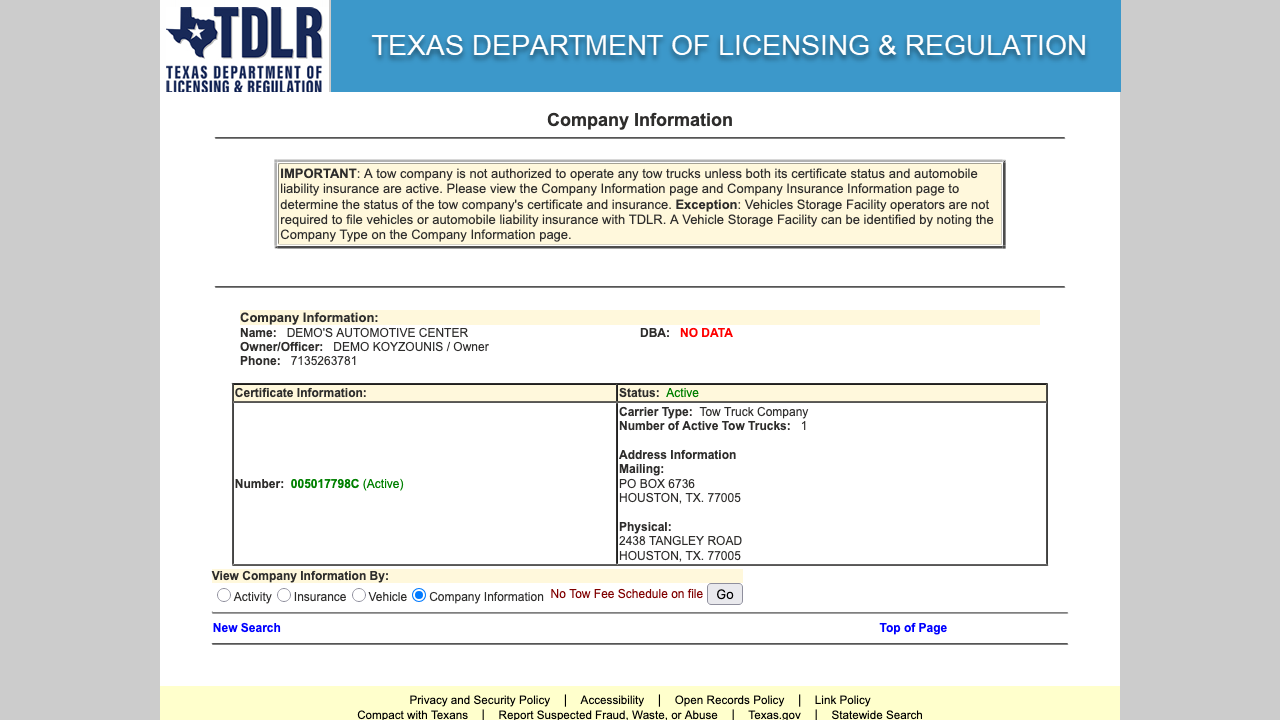

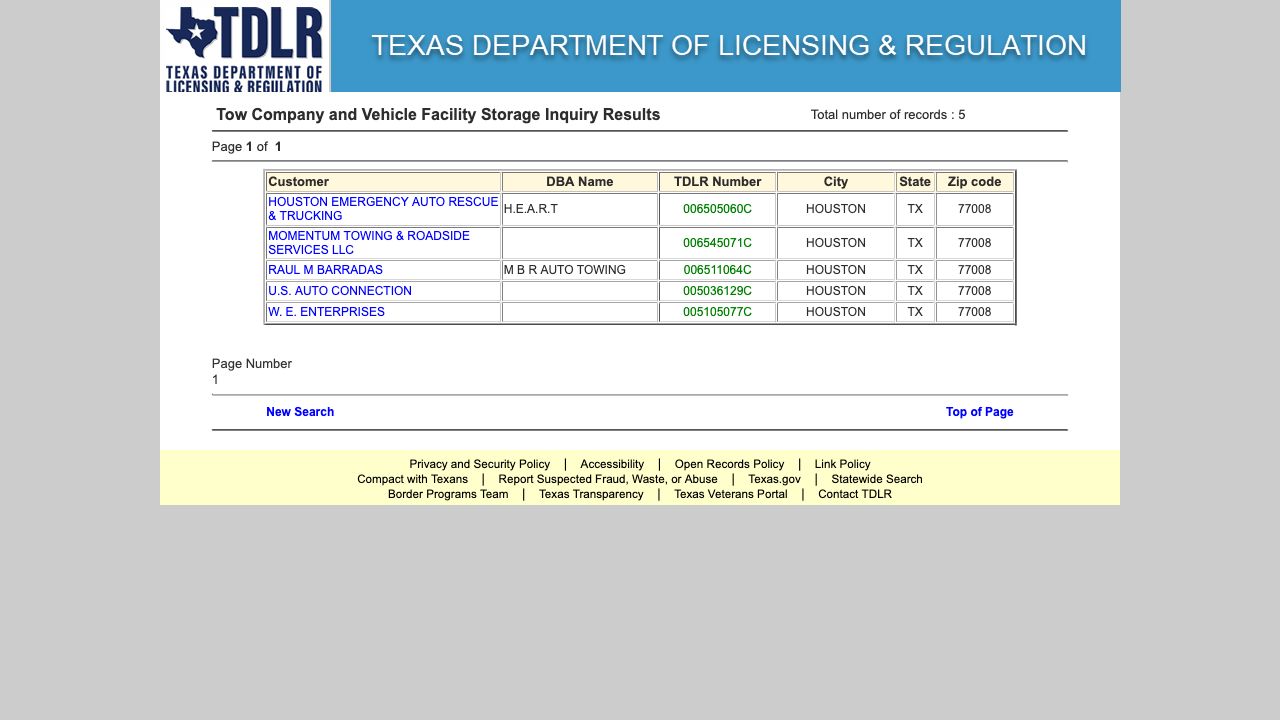

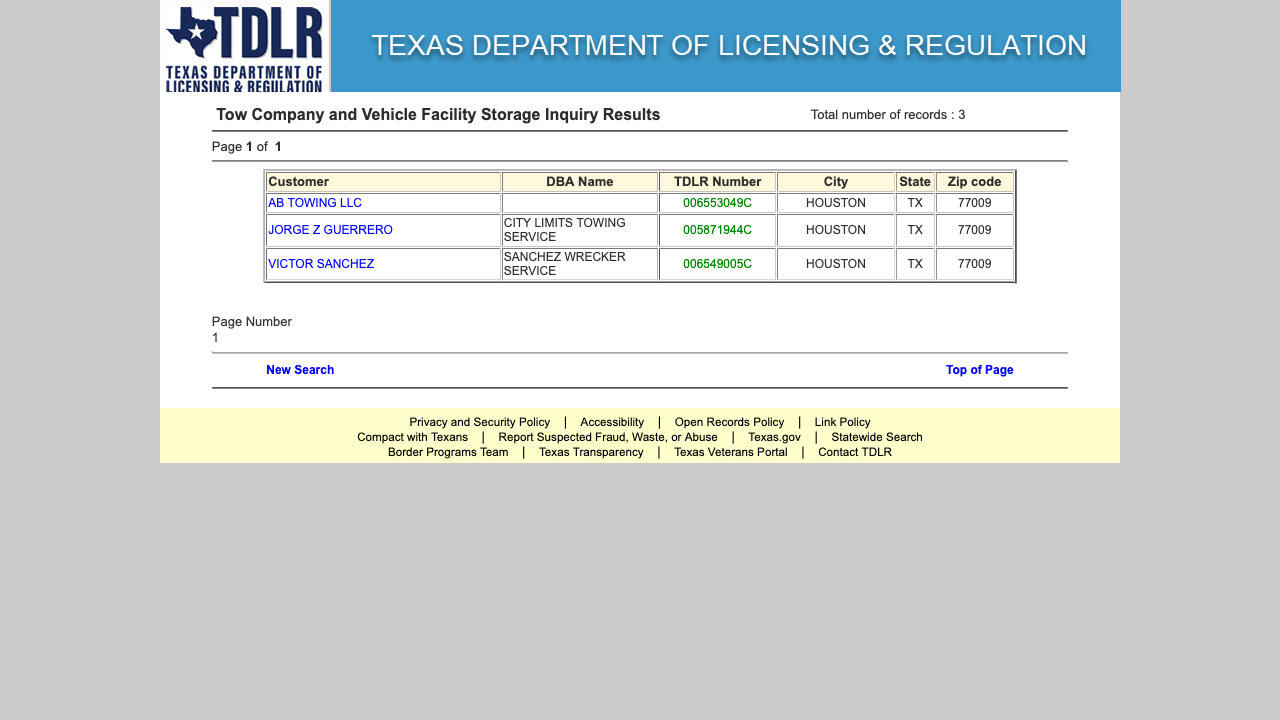

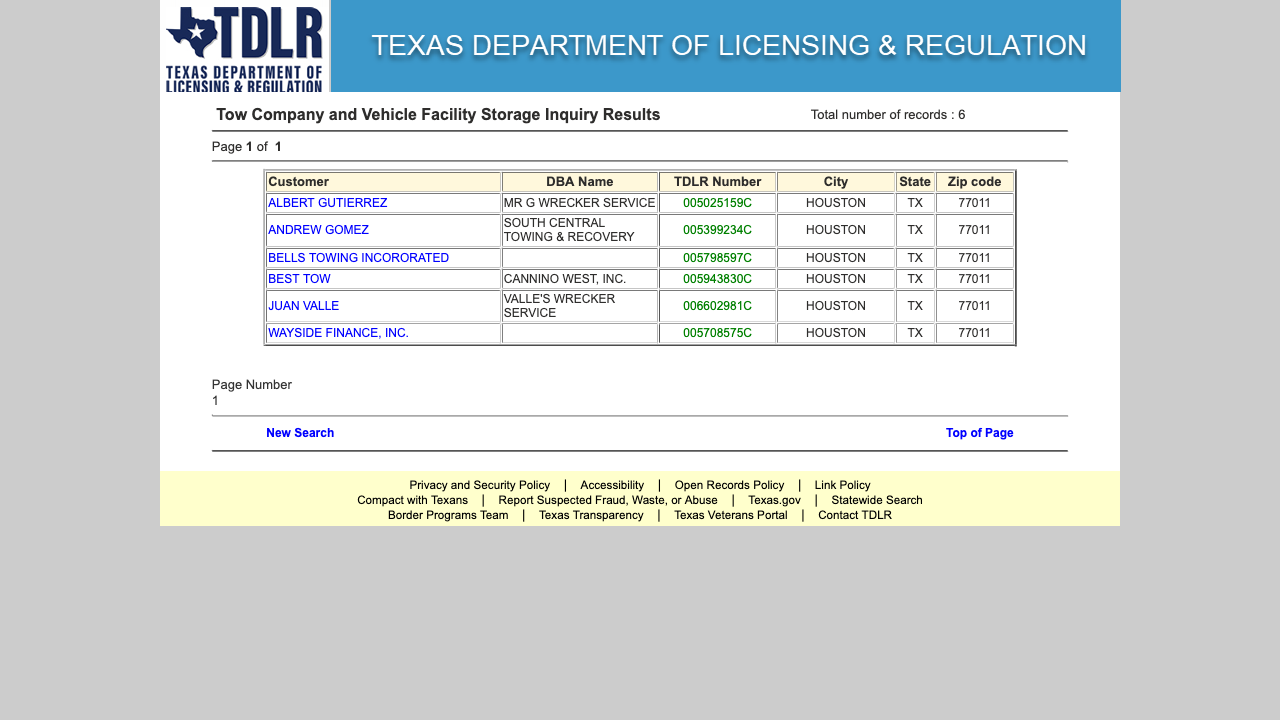

CSV saved as '/Users/luizaswierzawska1/Desktop/tow_truck_licenses/tow_truck_licenses.csv'


In [10]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Image
import os
import re

# List of ZIP codes to scrape
zip_codes = ["77002","77003","77004","77005","77006","77007","77008","77009","77010","77011"]

async def scrape_zip(zip_code, headless=False):
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=headless)
        context = await browser.new_context()
        page = await context.new_page()
        
        await page.goto("https://www.tdlr.texas.gov/tools_search/", wait_until="networkidle")
        
        # Activate ZIP search
        await page.click('#zipcodebutton')
        await page.fill('#zipcodedata', zip_code)
        
        # Set Tow Truck and Active
        await page.select_option('#zip_carrier_type', 'tow')
        await page.select_option('#zip_status', 'A')
        
        # Click Search
        await page.click('#submit3')
        
        # Wait for results or "No results"
        try:
            await page.wait_for_selector('table[bordercolor="black"]', timeout=10000)
        except:
            return [[zip_code, "No results", "", "", "", "", ""]]
        
        # Screenshot for verification (optional)
        screenshot = await page.screenshot()
        display(Image(screenshot))
        
        # Extract HTML and parse with BeautifulSoup
        content = await page.content()
        soup = BeautifulSoup(content, "html.parser")
        
        tables = soup.find_all("table", {"bordercolor": "black"})
        results = []
        
        for table in tables:
            html = str(table)
            
            cert_match = re.search(r'Number:&nbsp;&nbsp;<font.*?><b>(.*?)</b>', html)
            cert_number = cert_match.group(1) if cert_match else ""
            
            status_match = re.search(r'Status:</strong>&nbsp;&nbsp;<font.*?>(.*?)<', html)
            status = status_match.group(1) if status_match else ""
            
            carrier_match = re.search(r'Carrier Type:</strong>&nbsp;&nbsp;(.*?)<br>', html, re.DOTALL)
            carrier_type = carrier_match.group(1).strip() if carrier_match else ""
            
            trucks_match = re.search(r'Number of Active Tow Trucks:</b>\s*(\d+)', html)
            num_trucks = trucks_match.group(1) if trucks_match else ""
            
            mailing_match = re.search(r'<strong>Mailing:</strong><br>\s*(.*?)<br>\s*(.*?),&nbsp;TX.&nbsp;(\d{5})', html, re.DOTALL)
            mailing_address = ""
            if mailing_match:
                mailing_address = f"{mailing_match.group(1).strip()}, {mailing_match.group(2).strip()}, TX {mailing_match.group(3)}"
            
            physical_match = re.search(r'<strong>Physical:</strong><br>\s*(.*?)<br>\s*(.*?),&nbsp;TX.&nbsp;(\d{5})', html, re.DOTALL)
            physical_address = ""
            if physical_match:
                physical_address = f"{physical_match.group(1).strip()}, {physical_match.group(2).strip()}, TX {physical_match.group(3)}"
            
            results.append([
                zip_code,
                cert_number,
                status,
                carrier_type,
                num_trucks,
                mailing_address,
                physical_address
            ])
        
        await browser.close()
        return results

async def scrape_all_zips():
    all_results = []
    for z in tqdm(zip_codes, desc="Scraping ZIP codes"):
        try:
            data = await scrape_zip(z)
            all_results.extend(data)
        except Exception as e:
            all_results.append([z, f"Error: {e}", "", "", "", "", ""])
    
    df = pd.DataFrame(all_results, columns=[
        'ZIP Code',
        'Certificate Number',
        'Status',
        'Carrier Type',
        'Number of Active Tow Trucks',
        'Mailing Address',
        'Physical Address'
    ])
    return df

# Run scraper in Jupyter
loop = asyncio.get_event_loop()
df = loop.run_until_complete(scrape_all_zips())

# Preview
df.head()

# Save CSV to Desktop folder
desktop_folder = os.path.join(os.path.expanduser("~"), "Desktop", "tow_truck_licenses")
os.makedirs(desktop_folder, exist_ok=True)
output_file = os.path.join(desktop_folder, "tow_truck_licenses.csv")
df.to_csv(output_file, index=False)
print(f"CSV saved as '{output_file}'")


### Company information+violations for the license numbers saved in a separate csv. 

In [ ]:
# Load the subset CSV
df_subset = pd.read_csv("/Users/luizaswierzawska1/Desktop/cool-things-soma/trucks-subset.csv")

# Preview first few rows
df_subset.head()

,TDLR Number
0,006565540C
1,0654479VSF
2,006564940C


In [12]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Image
import os
import re

# Load license numbers
license_numbers = df_subset["TDLR Number"].astype(str).tolist()
print(f"Found {len(license_numbers)} license numbers to scrape.")

Found 3 license numbers to scrape.


In [13]:
async def scrape_license(license_number, headless=True):
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=headless)
        context = await browser.new_context()
        page = await context.new_page()

        await page.goto("https://www.tdlr.texas.gov/tools_search/", wait_until="networkidle")

        # Activate TDLR Number search
        await page.click('#mcrbutton')
        await page.fill('#mcrdata', license_number)

        # Click Search button
        await page.click('#submit3')

        # Wait for results table or "No results"
        try:
            await page.wait_for_selector('table[bordercolor="black"]', timeout=10000)
        except:
            await browser.close()
            return {
                "TDLR Number": license_number,
                "Company Name": "No results",
                "Status": "",
                "Carrier Type": "",
                "Number of Active Trucks": "",
                "Mailing Address": "",
                "Physical Address": "",
                "Violations": ""
            }

        # Optional screenshot for verification
        screenshot = await page.screenshot()
        display(Image(screenshot))

        # Parse page HTML with BeautifulSoup
        content = await page.content()
        soup = BeautifulSoup(content, "html.parser")
        table = soup.find("table", {"bordercolor": "black"})
        html = str(table)

        # Extract company information
        cert_match = re.search(r'Number:&nbsp;&nbsp;<font.*?><b>(.*?)</b>', html)
        company_name = cert_match.group(1) if cert_match else ""

        status_match = re.search(r'Status:</strong>&nbsp;&nbsp;<font.*?>(.*?)<', html)
        status = status_match.group(1) if status_match else ""

        carrier_match = re.search(r'Carrier Type:</strong>&nbsp;&nbsp;(.*?)<br>', html, re.DOTALL)
        carrier_type = carrier_match.group(1).strip() if carrier_match else ""

        trucks_match = re.search(r'Number of Active Tow Trucks:</b>\s*(\d+)', html)
        num_trucks = trucks_match.group(1) if trucks_match else ""

        mailing_match = re.search(r'<strong>Mailing:</strong><br>\s*(.*?)<br>\s*(.*?),&nbsp;TX.&nbsp;(\d{5})', html, re.DOTALL)
        mailing_address = f"{mailing_match.group(1).strip()}, {mailing_match.group(2).strip()}, TX {mailing_match.group(3)}" if mailing_match else ""

        physical_match = re.search(r'<strong>Physical:</strong><br>\s*(.*?)<br>\s*(.*?),&nbsp;TX.&nbsp;(\d{5})', html, re.DOTALL)
        physical_address = f"{physical_match.group(1).strip()}, {physical_match.group(2).strip()}, TX {physical_match.group(3)}" if physical_match else ""

        # Extract violations / enforcement actions
        violations = []
        violation_tables = soup.find_all("table", {"bordercolor": "gray"})
        for vtable in violation_tables:
            rows = vtable.find_all("tr")[1:]  # skip header
            for row in rows:
                cols = row.find_all("td")
                if len(cols) >= 2:
                    violations.append(cols[0].get_text(strip=True) + ": " + cols[1].get_text(strip=True))
        violations_text = " | ".join(violations) if violations else ""

        await browser.close()

        return {
            "TDLR Number": license_number,
            "Company Name": company_name,
            "Status": status,
            "Carrier Type": carrier_type,
            "Number of Active Trucks": num_trucks,
            "Mailing Address": mailing_address,
            "Physical Address": physical_address,
            "Violations": violations_text
        }

In [14]:
async def scrape_all_licenses(license_numbers):
    results = []
    for lic in tqdm(license_numbers, desc="Scraping license numbers"):
        try:
            data = await scrape_license(lic)
            results.append(data)
        except Exception as e:
            results.append({
                "TDLR Number": lic,
                "Company Name": f"Error: {e}",
                "Status": "",
                "Carrier Type": "",
                "Number of Active Trucks": "",
                "Mailing Address": "",
                "Physical Address": "",
                "Violations": ""
            })
    df = pd.DataFrame(results)
    return df


Scraping license numbers:   0%|          | 0/3 [00:00<?, ?it/s]

python(54789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


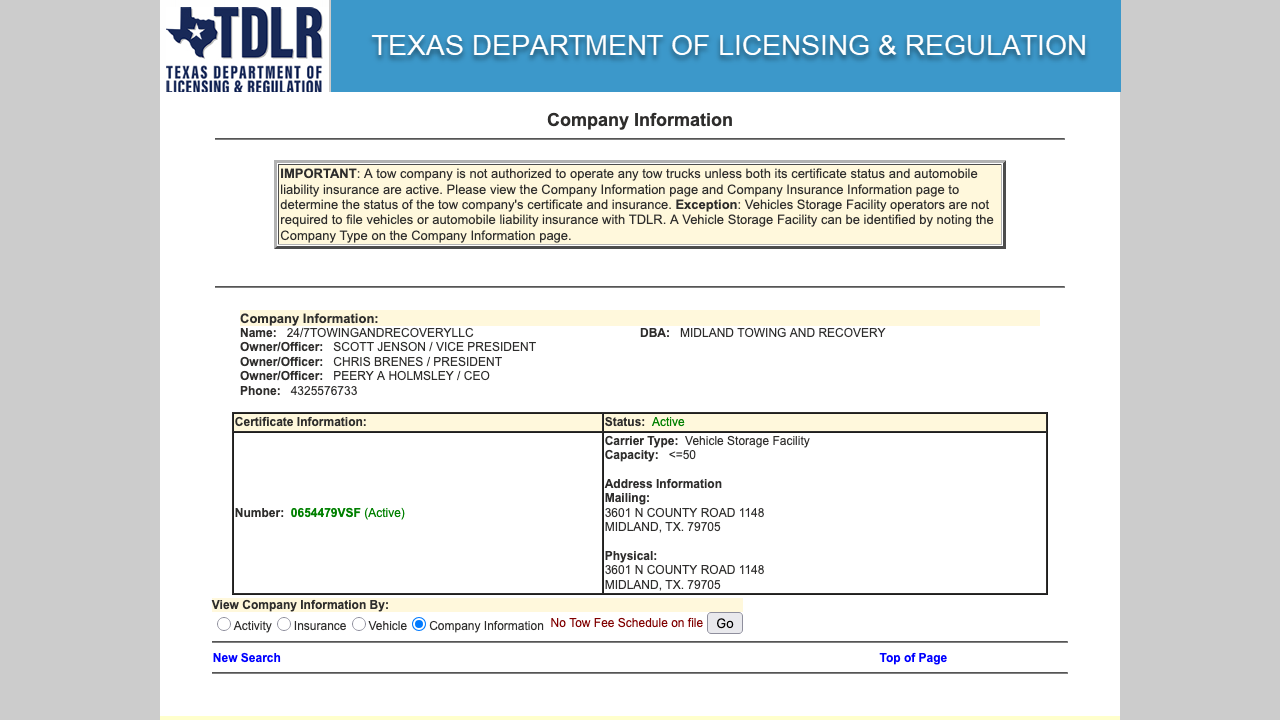

python(54805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


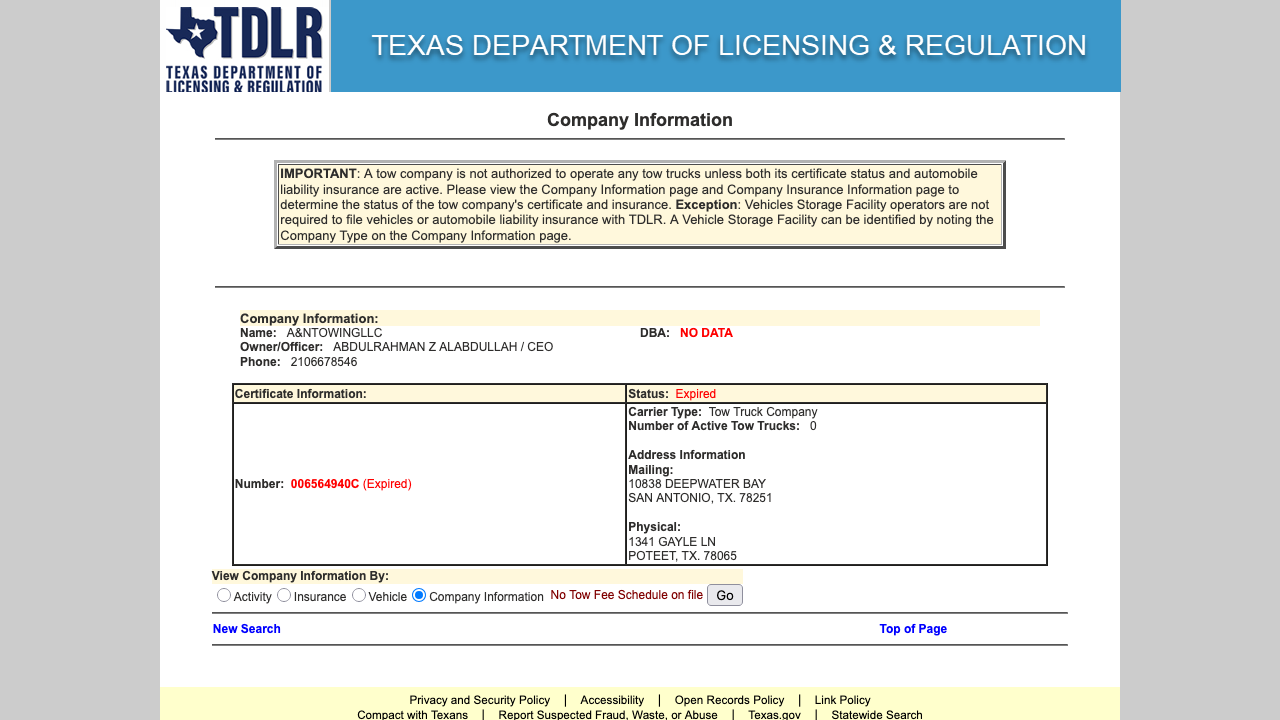

CSV saved as '/Users/luizaswierzawska1/Desktop/tdlr_licenses/trucks_licenses_with_violations.csv'


In [ ]:
#The code worked but wasn't saving the dataframe correctly

# Run scraper in Jupyter
loop = asyncio.get_event_loop()
df_licenses = loop.run_until_complete(scrape_all_licenses(license_numbers))

# Preview
df_licenses.head()

# Save CSV to Desktop folder
desktop_folder = os.path.join(os.path.expanduser("~"), "Desktop", "tdlr_licenses")
os.makedirs(desktop_folder, exist_ok=True)
output_file = os.path.join(desktop_folder, "trucks_licenses_with_violations.csv")
df_licenses.to_csv(output_file, index=False)
print(f"CSV saved as '{output_file}'")


In [16]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright
import pandas as pd
from tqdm.notebook import tqdm
import os

# Load license numbers
df_subset = pd.read_csv("/Users/luizaswierzawska1/Desktop/cool-things-soma/trucks-subset.csv")
license_numbers = df_subset["TDLR Number"].astype(str).tolist()
print(f"Loaded {len(license_numbers)} license numbers.")


# ---------------------------------------------------------
# FUNCTION: Scrape a single TDLR license page
# ---------------------------------------------------------
async def scrape_license(license_number, headless=True):
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=headless)
        page = await browser.new_page()
        await page.goto("https://www.tdlr.texas.gov/tools_search/", timeout=60000)

        # Select "TDLR Number"
        await page.click("#mcrbutton")
        await page.fill("#mcrdata", license_number.strip())

        # Search
        await page.click("#submit3")
        await page.wait_for_timeout(2500)

        # Check No Results
        no_result = await page.query_selector("text='No results'")
        if no_result:
            await browser.close()
            return {
                "License": license_number,
                "Company Name": "No results",
                "DBA Name": "",
                "Owners": "",
                "Phone": "",
                "Certificate Number": "",
                "Carrier Type": "",
                "Mailing Address": "",
                "Physical Address": "",
                "Violations": ""
            }

        # Storage
        data = {
            "License": license_number,
            "Company Name": "",
            "DBA Name": "",
            "Owners": [],
            "Phone": "",
            "Certificate Number": "",
            "Carrier Type": "",
            "Mailing Address": "",
            "Physical Address": "",
            "Violations": ""
        }

        # ---------------------------------------------------------
        # Extract all <strong> tags and the text inside parent <td>
        # ---------------------------------------------------------
        strong_tags = await page.query_selector_all("td strong")

        for strong in strong_tags:
            label_raw = await strong.inner_text()
            label = label_raw.replace(":", "").strip().lower()

            parent_td = await strong.evaluate_handle("node => node.parentElement")
            full_text = (await parent_td.inner_text()).replace("\xa0", " ").strip()
            cleaned = " ".join(full_text.split())

            # Parse fields
            if label == "number":
                # Format: "Number: 0654479VSF (Active)"
                data["Certificate Number"] = cleaned.replace("Number", "").replace("Active", "").strip()

            elif "carrier type" in label:
                # Format: "Carrier Type: Tow Truck"
                cp = cleaned.split("Carrier Type")[-1].strip()
                if cp.startswith(":"):
                    cp = cp[1:].strip()
                data["Carrier Type"] = cp

            elif label == "mailing":
                # Extract everything between Mailing and Physical
                block = cleaned.split("Mailing")[-1].strip()
                if "Physical" in block:
                    block = block.split("Physical")[0].strip()
                data["Mailing Address"] = block

            elif label == "physical":
                block = cleaned.split("Physical")[-1].strip()
                data["Physical Address"] = block

            elif label == "name":
                data["Company Name"] = cleaned.replace("Name", "").strip()

            elif label == "dba":
                data["DBA Name"] = cleaned.replace("DBA", "").strip()

            elif "owner/officer" in label:
                owner = cleaned.replace("Owner/Officer", "").strip()
                if owner:
                    data["Owners"].append(owner)

            elif "phone" in label:
                data["Phone"] = cleaned.replace("Phone", "").strip()

        # Join owners list
        data["Owners"] = "; ".join(data["Owners"]) if data["Owners"] else ""

        # ---------------------------------------------------------
        # Extract Violations (red-bordered table)
        # ---------------------------------------------------------
        violations_table = await page.query_selector('table[bordercolor="#990000"]')
        if violations_table:
            rows = await violations_table.query_selector_all("tr")
            violations = []

            for r in rows[1:]:  # skip header
                cells = await r.query_selector_all("td")
                row_text = [ (await c.inner_text()).strip() for c in cells ]
                violations.append(" | ".join(row_text))

            data["Violations"] = "\n".join(violations) if violations else "None"
        else:
            data["Violations"] = "None"

        await browser.close()
        return data


# ---------------------------------------------------------
# RUN SCRAPER FOR ALL LICENSE NUMBERS
# ---------------------------------------------------------
async def scrape_all_licenses(license_numbers, headless=True):
    results = []
    for lic in tqdm(license_numbers, desc="Scraping TDLR Licenses"):
        try:
            entry = await scrape_license(lic, headless=headless)
            results.append(entry)
        except Exception as e:
            results.append({
                "License": lic,
                "Company Name": f"Error: {e}",
                "DBA Name": "",
                "Owners": "",
                "Phone": "",
                "Certificate Number": "",
                "Carrier Type": "",
                "Mailing Address": "",
                "Physical Address": "",
                "Violations": ""
            })
    return pd.DataFrame(results)


# Run
loop = asyncio.get_event_loop()
df = loop.run_until_complete(scrape_all_licenses(license_numbers, headless=True))

# Save CSV
output_dir = "/Users/luizaswierzawska1/Desktop/tdlr_licenses"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trucks_licenses_with_violations.csv")
df.to_csv(output_file, index=False)

print("Saved:", output_file)
df.head()


Loaded 3 license numbers.


Scraping TDLR Licenses:   0%|          | 0/3 [00:00<?, ?it/s]

python(54888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Saved: /Users/luizaswierzawska1/Desktop/tdlr_licenses/trucks_licenses_with_violations.csv


,License,Company Name,DBA Name,Owners,Phone,Certificate Number,Carrier Type,Mailing Address,Physical Address,Violations
0,006565540C,,,,,,,,,None
1,0654479VSF,: 24/7TOWINGANDRECOVERYLLC,: MIDLAND TOWING AND RECOVERY,: SCOTT JENSON / VICE PRESIDENT; : CHRIS BRENE...,: 4325576733,: 0654479VSF (),Vehicle Storage Facility Capacity: <=50 Addres...,": 3601 N COUNTY ROAD 1148 MIDLAND, TX. 79705",": 3601 N COUNTY ROAD 1148 MIDLAND, TX. 79705",None
2,006564940C,: A&NTOWINGLLC,,: ABDULRAHMAN Z ALABDULLAH / CEO,: 2106678546,: 006564940C (Expired),Tow Truck Company Number of Active Tow Trucks:...,": 10838 DEEPWATER BAY SAN ANTONIO, TX. 78251",": 1341 GAYLE LN POTEET, TX. 78065",None
